In [1]:
# Import everything we need
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub  # This is the library for using pre-trained models
import tensorflow_datasets as tfds

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


In [2]:
# Download the data
(train_data, validation_data), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:10%]', 'train[90%:95%]'], # Use only 10% of the data for training, 5% for validation
    with_info=True,
    as_supervised=True,
)

# Let's see what we're working with
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(f"Total examples in full dataset: {num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Examples in our small training set: {len(train_data)}")
print(f"Examples in our validation set: {len(validation_data)}")

Total examples in full dataset: 23262
Number of classes: 2
Examples in our small training set: 2326
Examples in our validation set: 1163


In [3]:
# Define the image size expected by our pre-trained model (MobileNetV2)
IMAGE_RES = 224

# Create a function to format the images
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0 # Resize and scale to [0,1]
    return image, label

# Apply this function to all our data and batch it for efficiency
BATCH_SIZE = 32

train_batches = train_data.shuffle(buffer_size=1000).map(format_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
# URL to the pre-trained model on TensorFlow Hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Create the feature extractor layer
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3)) # 3 for color channels (RGB)

In [5]:
# Freeze the variables in the feature extractor layer so we only train the new classifier
feature_extractor.trainable = False

In [6]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [7]:
# Train the model
EPOCHS = 6 # Start with a small number of epochs

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)



Epoch 1/6
73/73 [==============================] - 107s 1s/step - loss: 0.1553 - accuracy: 0.9441 - val_loss: 0.0612 - val_accuracy: 0.9828
Epoch 2/6
73/73 [==============================] - 84s 1s/step - loss: 0.0564 - accuracy: 0.9837 - val_loss: 0.0435 - val_accuracy: 0.9888
Epoch 3/6
73/73 [==============================] - 82s 1s/step - loss: 0.0419 - accuracy: 0.9884 - val_loss: 0.0400 - val_accuracy: 0.9880
Epoch 4/6
73/73 [==============================] - 83s 1s/step - loss: 0.0339 - accuracy: 0.9918 - val_loss: 0.0388 - val_accuracy: 0.9897
Epoch 5/6
73/73 [==============================] - 85s 1s/step - loss: 0.0277 - accuracy: 0.9940 - val_loss: 0.0376 - val_accuracy: 0.9905
Epoch 6/6
73/73 [==============================] - 79s 1s/step - loss: 0.0236 - accuracy: 0.9953 - val_loss: 0.0383 - val_accuracy: 0.9897


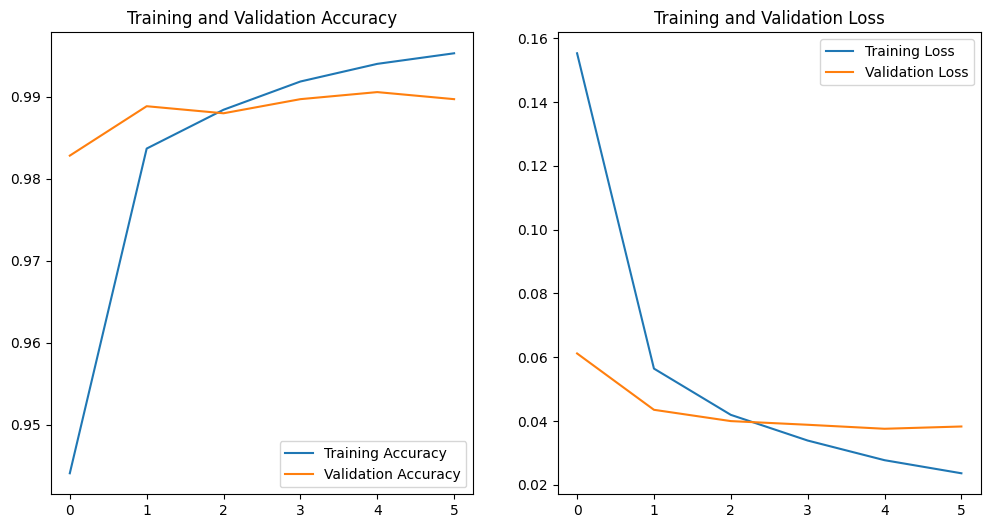

In [8]:
# Plot the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

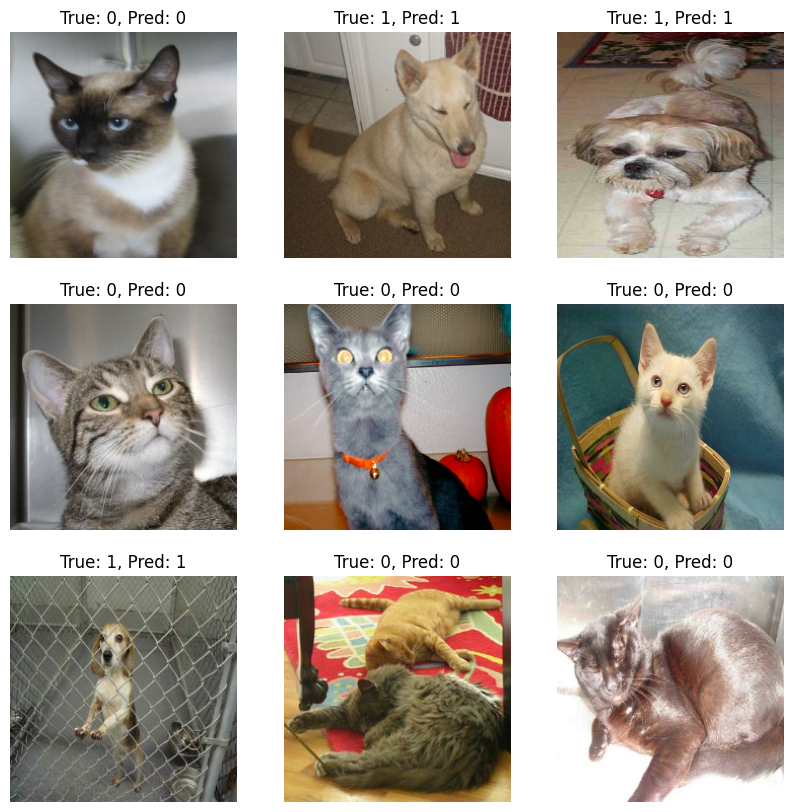

In [9]:
# Grab a batch of images and labels from the test set
image_batch, label_batch = validation_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).argmax(axis=-1) # Get the predicted class

# Plot the images with their true and predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title(f"True: {label_batch[i]}, Pred: {predictions[i]}")
    plt.axis("off")

In [10]:
# Examine outer image from the validation set
# Define your class names (Crucial for understanding the prediction!)
class_names = ['cat', 'dog'] # Index 0 is 'cat', Index 1 is 'dog'

# Let's double-check our model is ready to go
print(model.input_shape) # Should be (None, 224, 224, 3)

(None, 224, 224, 3)


In [19]:
def predict_image(image_path, model):
    """
    Loads an image from the specified path, preprocesses it,
    makes a prediction using the model, and returns the
    predicted class and confidence.
    """
    # 1. Load the image from disk
    img = tf.io.read_file(image_path)
    
    # 2. Decode it into a tensor
    img = tf.image.decode_image(img, channels=3) # Decode as 3-channel color
    # Note: decode_image doesn't have a static shape, so we need to set it
    
    # 3. Resize the image to the size the model expects (224x224)
    img = tf.image.resize(img, [224, 224])
    
    # 4. Scale the pixel values to [0, 1] (same as training)
    img = img / 255.0
    
    # 5. The model expects a batch of images as input.
    # So we add a new axis (batch dimension) at the start.
    # This changes the shape from (224, 224, 3) to (1, 224, 224, 3)
    img_batch = tf.expand_dims(img, axis=0)
    
    # 6. Now make a prediction!
    predictions = model.predict(img_batch, verbose=0) # verbose=0 stops extra output
    
    # 7. The output is a batch of predictions, we just take the first one.
    # The prediction is an array of probabilities for each class.
    # Example: [[0.15, 0.85]] -> 15% confidence for class 0 (cat), 85% for class 1 (dog)
    score = tf.nn.softmax(predictions[0]) # This ensures it's a proper probability distribution
    
    # 8. Find the class with the highest confidence and get its name
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    
    # 9. Print the result and return it
    print(f"This image most likely belongs to '{predicted_class}' with a {confidence:.2f}% confidence.")
    return predicted_class, confidence

# Example usage:
# predicted_class, confidence = predict_image('path/to/your/test_cat.jpg', model)

In [20]:
predicted_class, confidence = predict_image('C:/Users/owner/Desktop/Tutu/images.jpg', model)

This image most likely belongs to 'dog' with a 73.06% confidence.


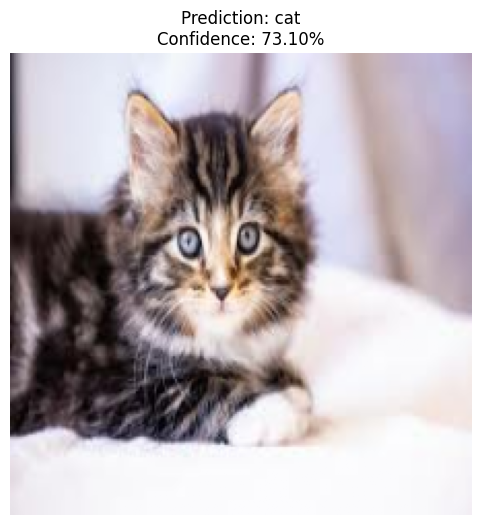

('cat', 73.10410141944885)

In [22]:
def predict_and_plot(image_path, model):
    # This part is the same as before for getting the prediction
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    img_batch = tf.expand_dims(img, axis=0)
    
    predictions = model.predict(img_batch, verbose=0)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    
    # Now let's plot it
    plt.figure(figsize=(6, 6))
    plt.imshow(img) # Show the image
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Use the new function
predict_and_plot('C:/Users/owner/Desktop/Tutu/images.jpg', model)